In [1]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val
from fbprophet import Prophet

import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 29651 (Greer, SC)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Greer = melted[melted.RegionName == 29651]
Greer = Greer.resample('MS').mean()
Greer = Greer.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

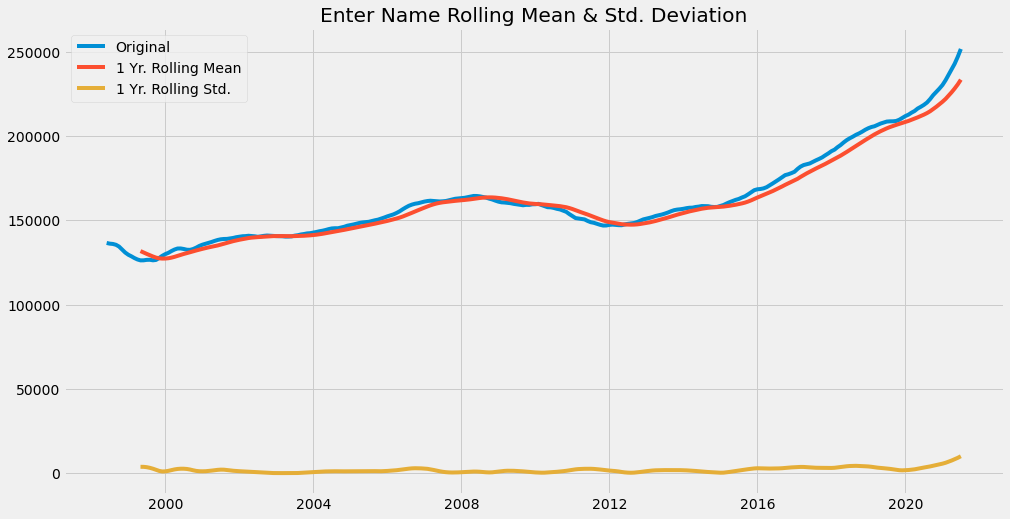

In [6]:
roll_mean_std(Greer)

### Seasonal Decompose

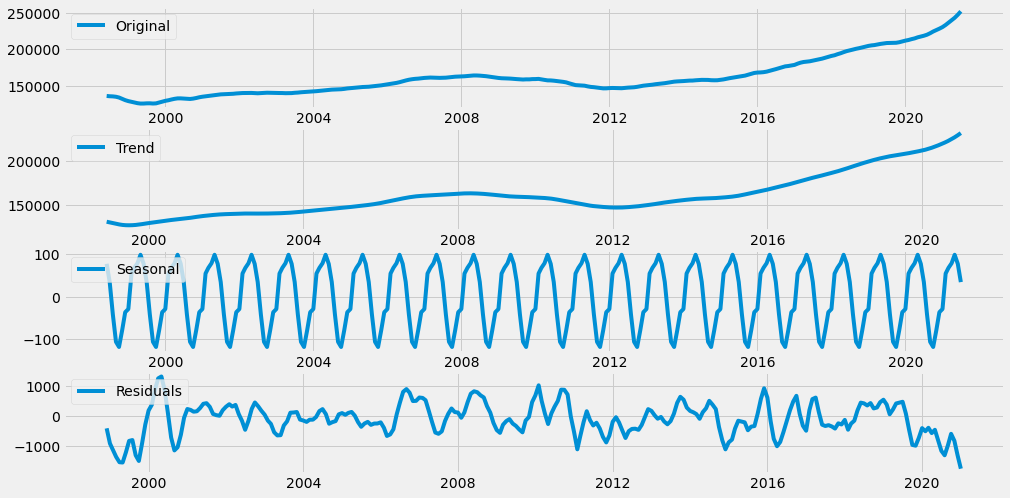

In [7]:
decompose(Greer)

### Differencing and DickeyFuller Test

In [8]:
DickeyFullerTest(Greer)

Test Statistic                   2.085268
p-value                          0.998774
# Lags Used                     16.000000
Number of Observations Used    261.000000
Critical Value (1%)             -3.455656
Critical Value (5%)             -2.872678
Critical Value (10%)            -2.572705
dtype: float64

Test Statistic                   1.149979
p-value                          0.995621
# Lags Used                     16.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64

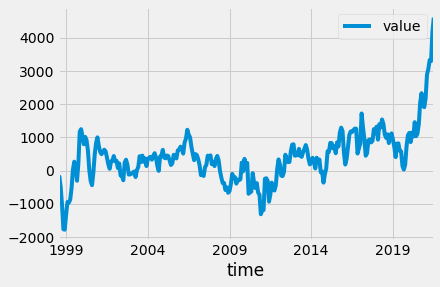

In [9]:
Greer_diff = Greer.diff().dropna()
Greer_diff.plot()
DickeyFullerTest(Greer_diff)

Test Statistic                  -3.354273
p-value                          0.012620
# Lags Used                     15.000000
Number of Observations Used    260.000000
Critical Value (1%)             -3.455754
Critical Value (5%)             -2.872721
Critical Value (10%)            -2.572728
dtype: float64

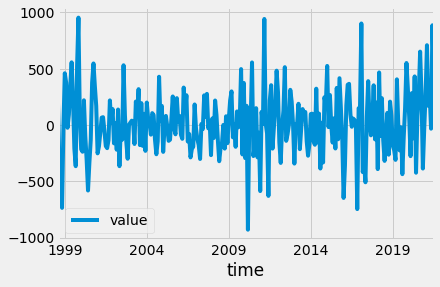

In [10]:
Greer_diff2 = Greer_diff.diff().dropna()
Greer_diff2.plot()
DickeyFullerTest(Greer_diff2)

### ACF and PACF

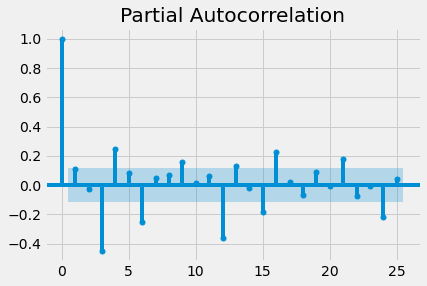

In [11]:
plot_pacf(Greer_diff2);

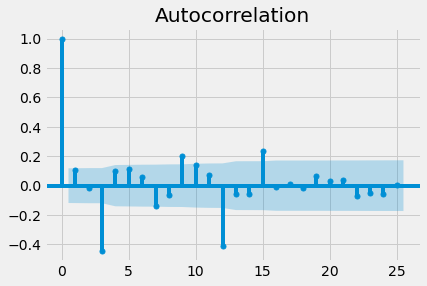

In [12]:
plot_acf(Greer_diff2);

### Train Test Split

In [13]:
cutoff = round(Greer.shape[0]*.8)
train = Greer[:cutoff]
test = Greer[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 588.89
The Naive Model RMSE for the test data is: 1627.9


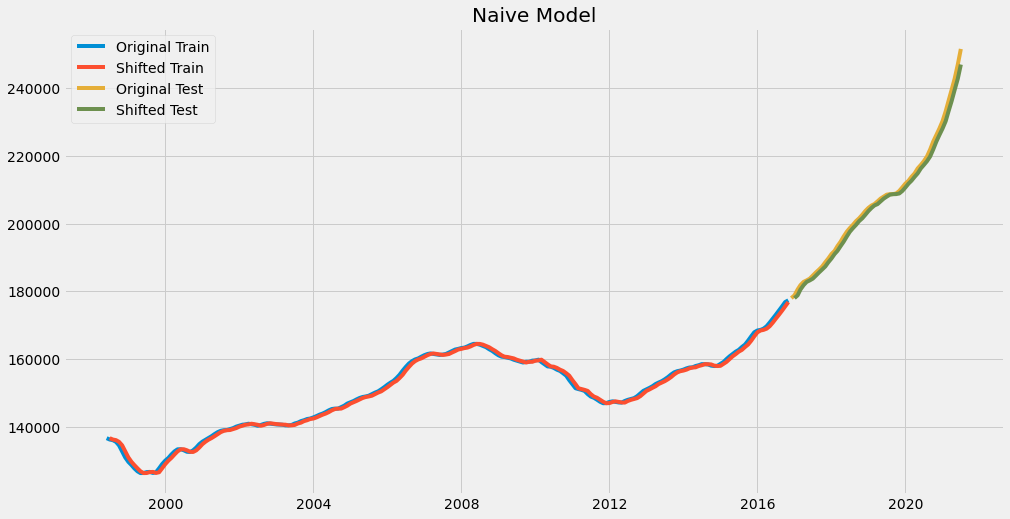

In [14]:
naive_model(train, test)

### SARIMAX GridSearch and Model

In [15]:
sarimax_search(train, p=range(1,3), d=range(1,3), q=range(1,2), maxiter=100)

THERE ARE 16 ITERATIONS
Would you like to run the models? (y or n)?y
SARIMAX (1, 1, 1) x (1, 1, 1, 12) - RMSE:11269.754301267398
SARIMAX (1, 1, 1) x (1, 2, 1, 12) - RMSE:14320.358530992158
SARIMAX (1, 1, 1) x (2, 1, 1, 12) - RMSE:11347.712322151874
SARIMAX (1, 1, 1) x (2, 2, 1, 12) - RMSE:13921.71571372855
SARIMAX (1, 2, 1) x (1, 1, 1, 12) - RMSE:14009.286398739325
SARIMAX (1, 2, 1) x (1, 2, 1, 12) - RMSE:16597.01437383696
SARIMAX (1, 2, 1) x (2, 1, 1, 12) - RMSE:14054.53773832171
SARIMAX (1, 2, 1) x (2, 2, 1, 12) - RMSE:16088.206991445411
SARIMAX (2, 1, 1) x (1, 1, 1, 12) - RMSE:12406.776286711827
SARIMAX (2, 1, 1) x (1, 2, 1, 12) - RMSE:16375.924027686428
SARIMAX (2, 1, 1) x (2, 1, 1, 12) - RMSE:11924.511439383838
SARIMAX (2, 1, 1) x (2, 2, 1, 12) - RMSE:15569.725202283038
SARIMAX (2, 2, 1) x (1, 1, 1, 12) - RMSE:14288.54601056987
SARIMAX (2, 2, 1) x (1, 2, 1, 12) - RMSE:15292.88512180067
SARIMAX (2, 2, 1) x (2, 1, 1, 12) - RMSE:14372.684451201028
SARIMAX (2, 2, 1) x (2, 2, 1, 12) - 

### Facebook Prophet Model

In [16]:
Greer_proph = Greer.reset_index()
Greer_proph = Greer_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 1129.436458473062
%RMSE:  y    0.006986
dtype: float64


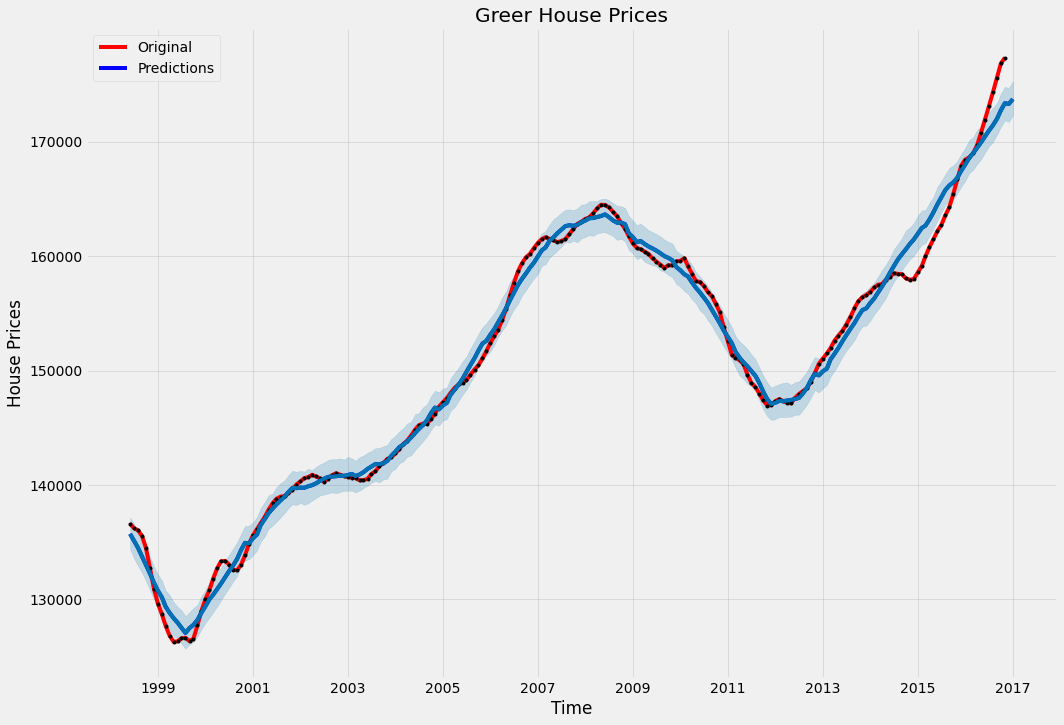

In [17]:
fbprophet_func(Greer_proph, periods=2, city = 'Greer')

### LSTM Model

In [18]:
history = LSTM_func(Greer_proph, City=Greer, epochs=200, verbose = 0, use_multiprocessing=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
RMSE: 1264.6176222674876
%RMSE:  253.08342420542246


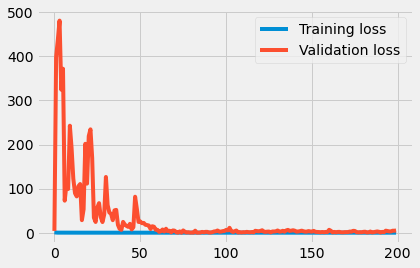

In [19]:
LSTM_val(history)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


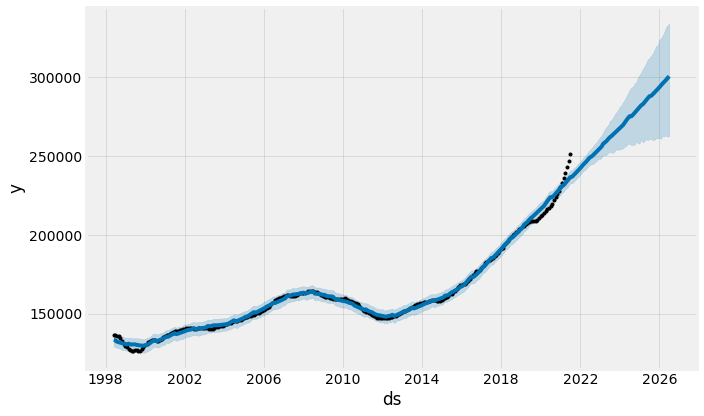

In [20]:
final_model = Prophet(interval_width=.95)
final_model.fit(Greer_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

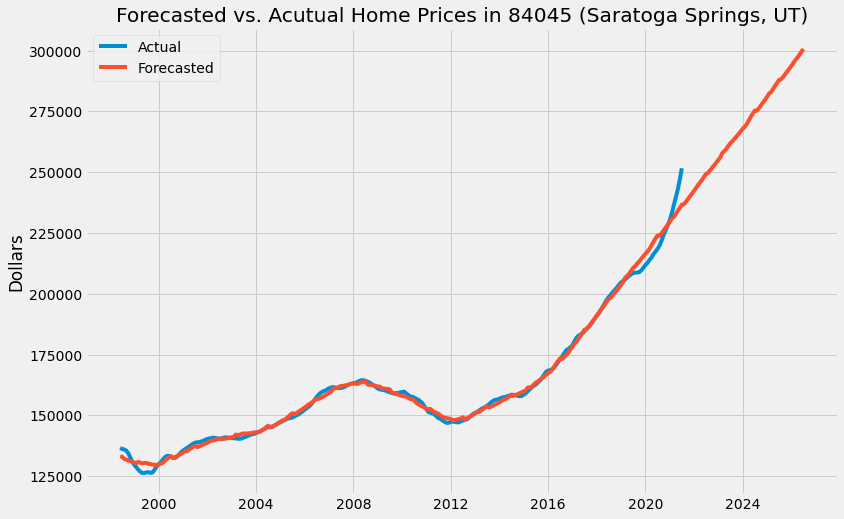

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Greer_proph.ds, Greer_proph.y, label='Actual')
ax.plot(forecast.ds, forecast.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 84045 (Saratoga Springs, UT)')
ax.set_ylabel('Dollars')
ax.legend();

In [22]:
current_price = int(Greer_proph[Greer_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $251637
Predicted 2026 price:         $300706
Predicted five year increase: $49069
Predicted five year ROI:      0.19499914559464626
